1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

In [2]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [36]:
df = pd.read_csv("data_kagle.csv")
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [37]:
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)
df['treatment']=df['treatment'].replace({'Buy One Get One': 1, 'Discount': 1,'No Offer': 0})
df['zip_code']=df['zip_code'].replace({'Surburban': 1, 'Rural': 2,'Urban': 3})
df['channel']=df['channel'].replace({'Multichannel': 1, 'Phone': 2,'Web': 3})
df.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,1,0,2,1,0
1,6,329.08,1,1,2,1,3,0,0
2,7,180.65,0,1,1,1,3,1,0
3,9,675.83,1,0,2,1,3,1,0
4,2,45.34,1,0,3,0,3,1,0


In [38]:
df["Id"]=df.index
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df

,Id,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,0,10,142.44,1,0,1,0,2,1,0
1,1,6,329.08,1,1,2,1,3,0,0
2,2,7,180.65,0,1,1,1,3,1,0
3,3,9,675.83,1,0,2,1,3,1,0
4,4,2,45.34,1,0,3,0,3,1,0
...,...,...,...,...,...,...,...,...,...,...
63995,63995,10,105.54,1,0,3,0,3,1,0
63996,63996,5,38.91,0,1,3,1,2,1,0
63997,63997,6,29.99,1,0,3,1,2,1,0
63998,63998,1,552.94,1,0,1,1,1,1,0


In [39]:
indices_learn, indices_valid  = train_test_split(df['Id'], test_size=0.3, random_state=20)

In [40]:
df_features= df.drop(['treatment', 'target'], axis=1)# признаки
df_train=df.drop(['recency','history','used_discount',
                  'used_bogo','zip_code','is_referral','channel'], axis=1) #id  и была ли покупка и коммуникация


In [41]:
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment']


In [46]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

In [45]:
models_results

{}

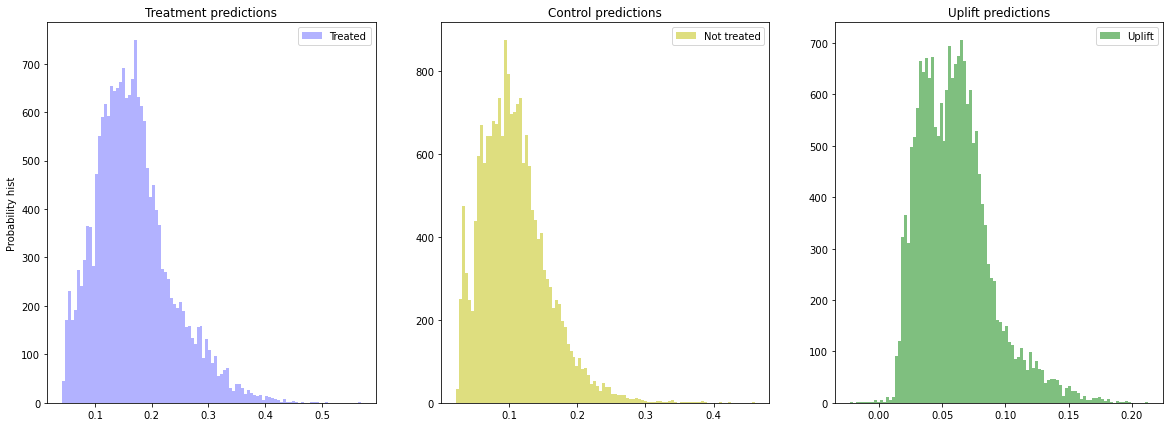

In [42]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_02 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score)
models_results['uplift@20%'].append(sm_score_02)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [25]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,treatment,14.666140
1,is_referral,14.647980
2,zip_code,12.760031
3,history,11.851407
4,recency,10.495990
5,used_bogo,10.376545
6,channel,9.545050
7,used_discount,8.134878
8,Id,7.521978


In [26]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score_02 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score)
models_results['uplift@20%'].append(ct_score_02)

<ipython-input-26-ac39d36e2803>:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train)


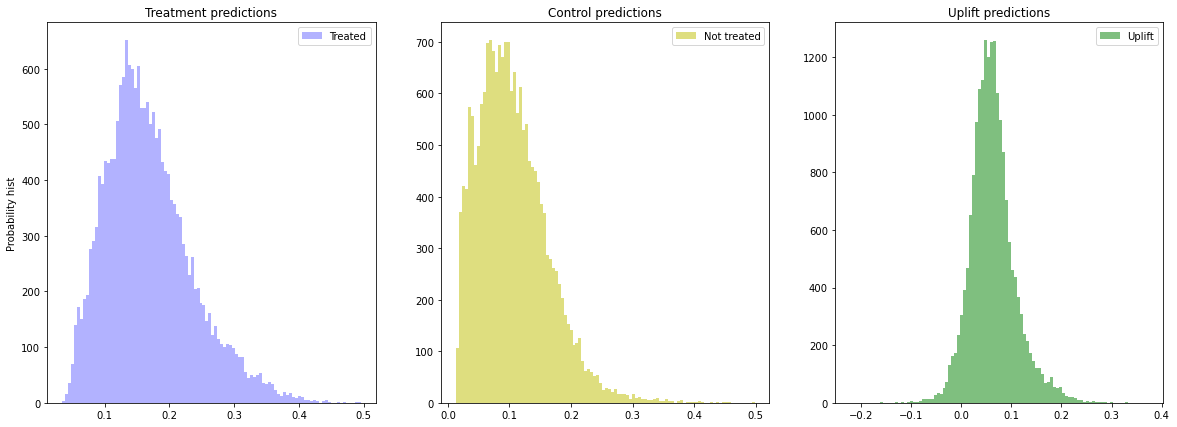

In [27]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train 
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score_02 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score)
models_results['uplift@20%'].append(tm_score_02)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [28]:
pd.DataFrame(data=models_results).sort_values('uplift@20%', ascending=False)

,approach,uplift@10%,uplift@20%
0,SoloModel,0.050289,0.067998
1,ClassTransformation,0.055271,0.061053
3,ClassTransformation,0.055271,0.061053
2,TwoModels,0.040694,0.044011
4,TwoModels,0.040694,0.044011


###  8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion

In [48]:
uplift_sm_train = sm.predict(X_train)
uplift_sm_train

array([0.05030131, 0.05378638, 0.04881463, ..., 0.06582524, 0.10312178,
       0.08137141])

In [72]:
X_train_uplift=X_train
X_train_uplift['uplift']=uplift_sm_train
X_train_uplift['conversion']=y_train

In [73]:
X_train_uplift=X_train_uplift.sort_values(['uplift'],ascending=False)
X_train_uplift.head(4)

,Id,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,uplift,conversion
13814,13814,1,287.72,1,1,2,0,3,0.216761,1
1820,1820,2,280.99,1,1,1,0,3,0.210305,0
22304,22304,1,291.55,1,1,2,0,2,0.204649,0
1777,1777,2,295.70,1,1,3,0,2,0.202938,1


In [74]:
X_train_uplift['qcut']=pd.qcut(X_train_uplift['uplift'], 4,labels=False)


In [75]:
X_train_uplift

,Id,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,uplift,conversion,qcut
13814,13814,1,287.72,1,1,2,0,3,0.216761,1,3
1820,1820,2,280.99,1,1,1,0,3,0.210305,0,3
22304,22304,1,291.55,1,1,2,0,2,0.204649,0,3
1777,1777,2,295.70,1,1,3,0,2,0.202938,1,3
17499,17499,2,273.07,1,1,3,0,2,0.200265,0,3
...,...,...,...,...,...,...,...,...,...,...,...
208,208,1,29.99,1,0,2,1,2,-0.009040,0,0
748,748,1,29.99,1,0,2,1,3,-0.009418,0,0
145,145,3,29.99,1,0,1,0,2,-0.012572,0,0
1724,1724,3,46.07,1,0,1,0,2,-0.013003,0,0


In [77]:
X_train_uplift_kat1 = X_train_uplift[X_train_uplift['qcut'] == 0]
X_train_uplift_kat1['conversion'].mean()

0.09695562896169985

In [78]:
X_train_uplift_kat2 = X_train_uplift[X_train_uplift['qcut'] == 1]
X_train_uplift_kat2['conversion'].mean()

0.12715421019733905

In [79]:
X_train_uplift_kat3 = X_train_uplift[X_train_uplift['qcut'] == 2]
X_train_uplift_kat3['conversion'].mean()

0.15165580648040702

In [80]:
X_train_uplift_kat4 = X_train_uplift[X_train_uplift['qcut'] == 3]
X_train_uplift_kat4['conversion'].mean()

0.21434312762347058